In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split

pd.options.display.max_columns=None
%matplotlib inline
sns.set()

In [2]:
def get_metrics(y_test, pred, probs):
    print('F1 Score: ', f1_score(y_test,pred))
    print('AUC Score: ', roc_auc_score(y_test,probs))
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.show()
    

In [3]:
def plot_feature_importance(importance):
  # criar um gráfico de barras para a importância relativa das variáveis
  plt.bar(range(len(X.columns)), importance)
  plt.xticks(range(len(X.columns)), X.columns.values, rotation=90)
  plt.title('Importância Relativa das Variáveis')
  plt.xlabel('Variáveis')
  plt.show()

In [4]:
data = pd.read_parquet('dataset_voos.parquet')

In [5]:
dataset_voos = data.drop(columns=['ICAO_origem','ICAO_destino','data','rota', 'partida_prevista','partida_real',
                                  'ano_partida','chegada_prevista', 'turno_chegada', 'chegada_real',
                                  'duracao_prevista_voo', 'duracao_real_voo','atraso_chegada','tempo_atraso',
                                  'time', 'date', 'hour','IATA','hora'])

In [6]:
dataset_voos.head()

,IATA_origem,IATA_destino,cia_aerea,atraso_partida,mes_partida,dia_partida,hora_partida,dia_semana,fim_de_semana,turno_partida,feriado,temperature_2m,precipitation,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,windspeed_100m,elevation,weathercode
0,REC,POA,AZUL,False,1,1,17,5,1,Tarde,1,28.3,0.0,0.0,46.0,22.0,3.0,80.0,16.9,12.9,17.0,51.0
1,REC,POA,AZUL,False,1,2,17,6,1,Tarde,0,28.1,0.0,0.0,44.0,16.0,10.0,79.0,20.2,25.1,17.0,51.0
2,REC,POA,AZUL,False,1,3,2,0,0,Madrugada,0,25.1,0.4,0.4,100.0,93.0,54.0,93.0,8.7,12.3,17.0,51.0
3,REC,POA,AZUL,False,1,3,17,0,0,Tarde,0,28.0,0.2,0.2,48.0,15.0,22.0,72.0,17.3,20.7,17.0,51.0
4,REC,POA,AZUL,False,1,4,2,1,0,Madrugada,0,25.5,0.2,0.2,44.0,24.0,28.0,19.0,10.4,14.7,17.0,51.0


In [7]:
# Transformacao de colunas que possuem dados categoricos
cat_columns = [
    'IATA_origem','IATA_destino', 'cia_aerea', 'turno_partida'
]

ord_enc = OrdinalEncoder()
dataset_voos[cat_columns] = ord_enc.fit_transform(dataset_voos[cat_columns])

In [8]:
target_map = {'False': 0, 'True': 1}
dataset_voos['atraso_partida'] = dataset_voos['atraso_partida'].map(str).map(target_map)

In [9]:
features = [
    'IATA_origem', 'IATA_destino', 'cia_aerea',
    'mes_partida', 'dia_partida', 'hora_partida', 'dia_semana',
    'fim_de_semana', 'turno_partida', 'feriado', 'temperature_2m',
    'precipitation', 'rain', 'cloudcover', 'cloudcover_low',
    'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'windspeed_100m',
    'elevation', 'weathercode'
]

In [10]:
X = dataset_voos[features]
y = dataset_voos['atraso_partida']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
rus = RandomUnderSampler(random_state=23)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=23)
X_train_res, y_train_res = rus.fit_resample(X_train,y_train)

### Regressão Logística

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logReg = LogisticRegression()
logReg.fit(X_train_res,y_train_res)


logReg_probs = logReg.predict_proba(X_test)[:,1]
logReg_pred = np.array([1 if p>.6 else 0 for p in logReg_probs])

F1 Score:  0.28318525394510013
AUC Score:  0.6424977394931285
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     90043
           1       0.26      0.32      0.28     13545

    accuracy                           0.79    103588
   macro avg       0.58      0.59      0.58    103588
weighted avg       0.81      0.79      0.80    103588



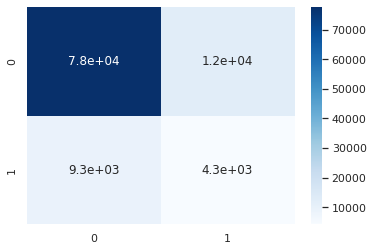

In [14]:
get_metrics(y_test, logReg_pred, logReg_probs)

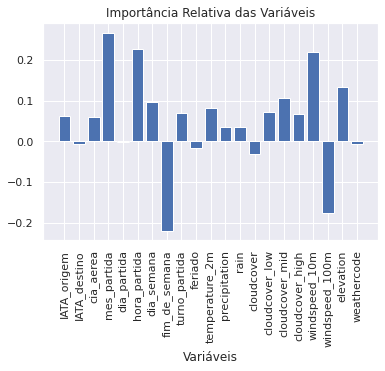

In [15]:
coef = logReg.coef_[0]

plot_feature_importance(coef)

### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train,y_train)


rf_probs = rf.predict_proba(X_test)[:,1]
rf_pred = np.array([1 if p>.25 else 0 for p in rf_probs])

F1 Score:  0.3347377500580566
AUC Score:  0.6929107255990613
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     90043
           1       0.30      0.37      0.33     13545

    accuracy                           0.81    103588
   macro avg       0.60      0.62      0.61    103588
weighted avg       0.82      0.81      0.81    103588



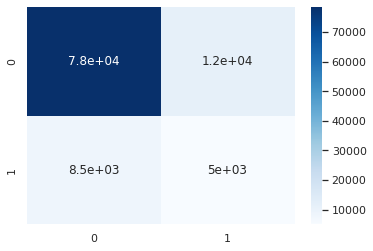

In [18]:
get_metrics(y_test, rf_pred, rf_probs)

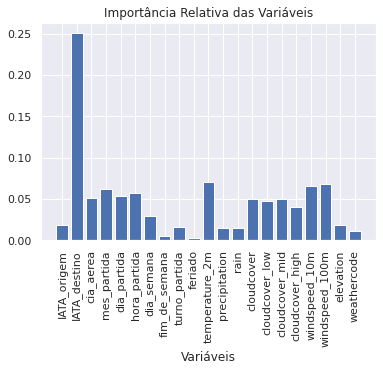

In [19]:
importances = rf.feature_importances_
plot_feature_importance(importances)

### XGBoost

In [20]:
import xgboost as xgb

In [21]:
boost = xgb.XGBClassifier(n_estimators=15,
                        max_depth=10,
                        gamma=1,
                        objective='binary:logistic',
                        max_delta_step=5,
                        learning_rate=0.2,
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8)

eval_set=[(X_train_res,y_train_res),(X_test,y_test)]

fit_model = boost.fit(X_train,y_train,eval_set=eval_set,eval_metric='auc',
                    early_stopping_rounds=20,verbose=True)

boost_probs = boost.predict_proba(X_test)[:,1]
boost_pred = np.array([1 if p>0.25 else 0 for p in boost_probs])

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.67896	validation_1-auc:0.66123
[1]	validation_0-auc:0.69300	validation_1-auc:0.66967
[2]	validation_0-auc:0.70204	validation_1-auc:0.67512
[3]	validation_0-auc:0.73411	validation_1-auc:0.70598
[4]	validation_0-auc:0.74807	validation_1-auc:0.71878
[5]	validation_0-auc:0.75520	validation_1-auc:0.72373
[6]	validation_0-auc:0.76028	validation_1-auc:0.72483
[7]	validation_0-auc:0.76557	validation_1-auc:0.72834
[8]	validation_0-auc:0.77024	validation_1-auc:0.73249
[9]	validation_0-auc:0.77344	validation_1-auc:0.73527
[10]	validation_0-auc:0.77730	validation_1-auc:0.73700
[11]	validation_0-auc:0.78072	validation_1-auc:0.73812
[12]	validation_0-auc:0.78325	validation_1-auc:0.73924
[13]	validation_0-auc:0.78712	validation_1-auc:0.74030
[14]	validation_0-auc:0.79104	validation_1-auc:0.74180


F1 Score:  0.3708265024591147
AUC Score:  0.7418005597727482
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     90043
           1       0.40      0.34      0.37     13545

    accuracy                           0.85    103588
   macro avg       0.65      0.63      0.64    103588
weighted avg       0.84      0.85      0.84    103588



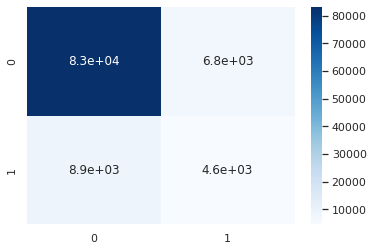

In [22]:
get_metrics(y_test, boost_pred, boost_probs)

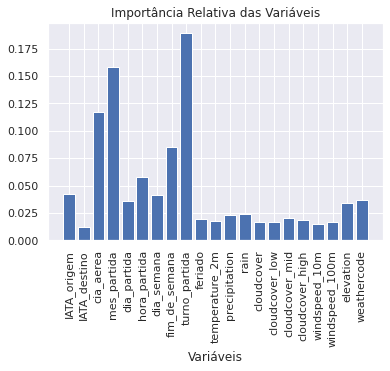

In [23]:
importances = boost.feature_importances_
plot_feature_importance(importances)

### Comparação Modelos

Logistic AUC:  0.6424977394931285
Random Forest AUC:  0.6929107255990613
XG Boost AUC:  0.7418005597727482


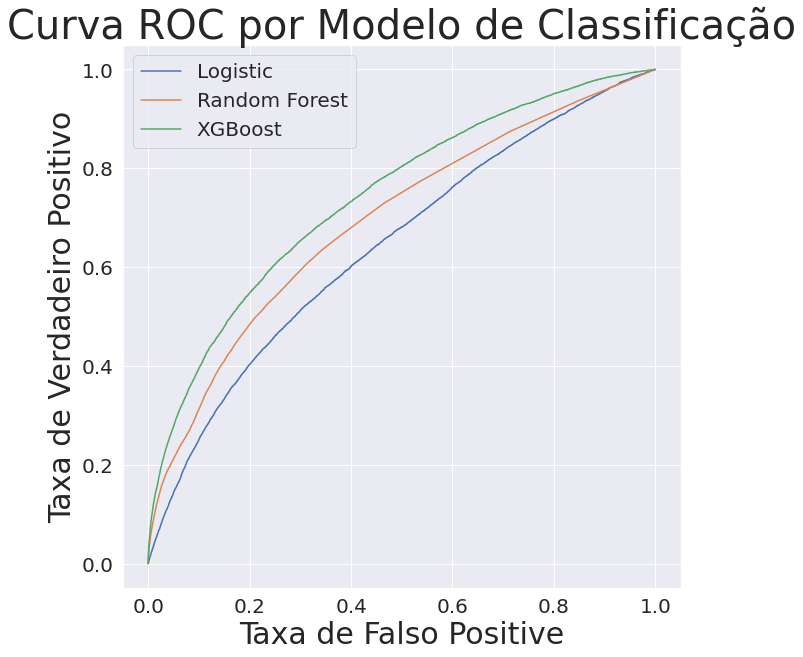

In [24]:
tpr_log, fpr_log, thresholds_log = roc_curve(y_test,logReg_probs)
tpr_rf, fpr_rf, thresholds_rf = roc_curve(y_test,rf_probs)
tpr_boost, fpr_boost, thresholds_boost = roc_curve(y_test,boost_probs)

print('Logistic AUC: ', roc_auc_score(y_test,logReg_probs))
print('Random Forest AUC: ', roc_auc_score(y_test,rf_probs))
print('XG Boost AUC: ', roc_auc_score(y_test,boost_probs))

plt.figure(figsize=(10,10))
plt.plot(tpr_log,fpr_log,label='Logistic')
plt.plot(tpr_rf,fpr_rf,label='Random Forest')
plt.plot(tpr_boost,fpr_boost,label='XGBoost')
plt.title('Curva ROC por Modelo de Classificação',fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Taxa de Falso Positive',fontsize=30)
plt.ylabel('Taxa de Verdadeiro Positivo',fontsize=30)
plt.legend(fontsize=20)
plt.savefig('comparacao_modelos.png',dpi=400);